# Predictive Uncertainty Estimation using Deep Ensemble (Classification)

This algorithm is implementation of paper [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474). In this jupyter notebook, I will implement classification part of this paper using MNIST and notMNIST dataset. 

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import cv2
import random

## Parameters

In [2]:
# Parameters of data
img_size = 28
img_flat_size = img_size * img_size

num_label = 10 # 0 ~ 9

# Parameters of training
Learning_rate = 0.0005
epsilon = 1e-8

num_iter = 1000
batch_size = 256

validation_ratio = 0.1
gpu_fraction = 0.5

# Ensemble networks
networks = ['network1', 'network2', 'network3', 'network4', 'network5']

# Convolution [kernel size, kernel size, # input, # output]
first_conv  = [3,3, 1,32]
second_conv = [3,3,32,64]

# Dense [input size, output size]
first_dense  = [7*7*64, num_label]


## Get MNIST Dataset

In [3]:
# Import MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

# Dataset for train, test, validation
test_len = mnist.test.images.shape[0]
validation_len = int(test_len * validation_ratio)

train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y_index = mnist.train.labels
test_y_index = mnist.test.labels[validation_len : test_len]
validation_y_index = mnist.test.labels[ : validation_len]

train_y = np.zeros([train_y_index.shape[0], num_label])
test_y = np.zeros([test_y_index.shape[0], num_label])
validation_y = np.zeros([validation_y_index.shape[0], num_label])

for i in range(train_y.shape[0]):
    train_y[i, train_y_index[i]] = 1

for i in range(test_y.shape[0]):
    test_y[i, test_y_index[i]] = 1
    
for i in range(validation_y.shape[0]):
    validation_y[i, validation_y_index[i]] = 1
    
print("\nTraining X shape: " + str(train_x.shape))
print("Testing X shape: " + str(test_x.shape))
print("Validation X shape: " + str(validation_x.shape))

print("\nTraining Y shape: " + str(train_y.shape))
print("Testing Y shape: " + str(test_y.shape))
print("Validation Y shape: " + str(validation_y.shape))

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Training X shape: (60000, 784)
Testing X shape: (9000, 784)
Validation X shape: (1000, 784)

Training Y shape: (60000, 10)
Testing Y shape: (9000, 10)
Validation Y shape: (1000, 10)


## Get NotMNIST Dataset

In [4]:
folders_notMNIST = os.listdir('./notMNIST_small')

NotMNIST_x_list = []
NotMNIST_y_list = []

for idx, folder in enumerate(folders_notMNIST):
    files_notMNIST = os.listdir('./notMNIST_small/' + folder)
    
    for file in files_notMNIST:
        img_NotMNIST = cv2.imread('./notMNIST_small/' + folder + '/' + file, 0)
        NotMNIST_flat = np.reshape(img_NotMNIST, (img_flat_size))
        NotMNIST_x_list.append(NotMNIST_flat)
        
        label_temp = np.zeros([num_label])
        label_temp[idx] = 1
        
        NotMNIST_y_list.append(label_temp)
        
NotMNIST_x = np.stack(NotMNIST_x_list, axis = 0)
NotMNIST_y = np.stack(NotMNIST_y_list, axis = 0)

print("NotMNIST X shape: " + str(NotMNIST_x.shape))
print("NotMNIST Y shape: " + str(NotMNIST_y.shape))

NotMNIST X shape: (18724, 784)
NotMNIST Y shape: (18724, 10)


## Sample image of MNIST

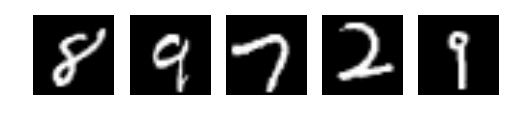

In [5]:
num_sample = 5

MNIST_sample_index    = np.random.choice(train_x.shape[0], num_sample)

# MNIST plotting
f_Mnist, ax_Mnist = plt.subplots(1, num_sample)

for i in range(num_sample):
    img_MNIST = np.reshape(train_x[MNIST_sample_index[i]], (img_size, img_size))
    ax_Mnist[i].imshow(img_MNIST, cmap='gray')
    ax_Mnist[i].axis('off')

plt.show()

## Sample image of NotMNIST

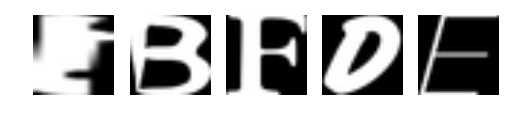

In [6]:
NotMNIST_sample_index = np.random.choice(NotMNIST_x.shape[0], num_sample)

# NotMNIST plotting
f_NotMnist, ax_NotMnist = plt.subplots(1, num_sample)

for i in range(num_sample):
    img_NotMNIST = np.reshape(NotMNIST_x[NotMNIST_sample_index[i]], (img_size, img_size))
    ax_NotMnist[i].imshow(img_NotMNIST, cmap='gray')
    ax_NotMnist[i].axis('off')

plt.show()

## Functions

In [38]:
tf.reset_default_graph()

# function for conv2d
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

# function for max pool
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def conv_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer_conv2d())

def weight_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer())

# Get networks
def get_network(network_name):
    x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, 1])
    
    with tf.variable_scope(network_name):
        # Convolution variables
        w_conv1 = conv_variable(network_name + '_w_conv1', first_conv)
        b_conv1 = bias_variable(network_name + '_b_conv1', [first_conv[3]])

        w_conv2 = conv_variable(network_name + '_w_conv2', second_conv)
        b_conv2 = bias_variable(network_name + '_b_conv2', [second_conv[3]])

        # Densely connect layer variables
        w_fc1 = weight_variable(network_name + '_w_fc1', first_dense)
        b_fc1 = bias_variable(network_name + '_b_fc1', [first_dense[1]])
         

    # Network
    h_conv1 = tf.nn.relu(conv2d(x_image, w_conv1, 1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    h_conv2 = tf.nn.relu(conv2d(h_pool1, w_conv2, 1) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, first_dense[0]])
    
    logits = tf.matmul(h_pool2_flat, w_fc1) + b_fc1
    output = tf.nn.softmax(logits)
    
    y_label = tf.placeholder(tf.float32, shape = [None, num_label])
    
    # Brier Score 
    loss = tf.reduce_mean(tf.div(tf.reduce_sum(tf.square(tf.subtract(output, y_label)), axis = 1), num_label), axis = 0) 
   
    # Get trainable variables
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name) 
    
    train_opt = tf.train.AdamOptimizer(Learning_rate).minimize(loss, var_list = train_vars)
    
    return x_image, y_label, output, loss, train_opt, train_vars


# Make batch data 
def making_batch(data_size, sample_size, data_x, data_y):
    # Making batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, img_size, img_size, 1])
    batch_y = np.zeros([sample_size, num_label])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:,:,:] = np.reshape(data_x[batch_idx[i], :], (img_size, img_size, 1))
        batch_y[i,:]     = data_y[batch_idx[i], :] 
        
    return batch_x, batch_y

# Calculate Accuracy
def get_accuracy(prediction, label):
    count_correct = 0
    for j in range(prediction.shape[0]):
        if np.argmax(label[j, :]) == np.argmax(prediction[j, :]):
            count_correct += 1.0
    
    acc = count_correct / label.shape[0]
    return acc 
    

## Initialize Ensemble Networks

In [39]:
x_list = []
y_list = []
output_list = []
loss_list = []
train_list = []
train_var_list = []

# Train each ensemble network
for i in range(len(networks)):
    x_image, y_label, output, loss, train_opt, train_vars = get_network(networks[i])

    x_list.append(x_image)
    y_list.append(y_label)
    output_list.append(output)
    loss_list.append(loss)
    train_list.append(train_opt)
    train_var_list.append(train_vars)


## Create Session

In [40]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Training

In [41]:
# Initialize data for printing
loss_check     = np.zeros(len(networks))
acc_check      = np.zeros(len(networks))
acc_check_test = np.zeros(len(networks))
acc_check_test_final = 0

# Set parameters for printing and testing
num_print = 100
test_size = 10

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]

for iter in range(num_iter):
    output_temp = np.zeros([test_size, num_label])

    # Making batches(testing)
    batch_x_test, batch_y_test = making_batch(test_data_num, test_size, test_x, test_y)
        
    for i in range(len(networks)):
        # Making batches(training)
        batch_x, batch_y = making_batch(train_data_num, batch_size, train_x, train_y)
       
        # Training
        _, loss, prob = sess.run([train_list[i], loss_list[i], output_list[i]], 
                                 feed_dict = {x_list[i]: batch_x, y_list[i]: batch_y})
        
        # Testing
        loss_test, prob_test = sess.run([loss_list[i], output_list[i]], 
                                         feed_dict = {x_list[i]: batch_x_test, y_list[i]: batch_y_test})
        
        # Add test prediction for get final prediction
        output_temp += prob_test
        
        # Calculate Accuracy (Training)
        acc_training = get_accuracy(prob, batch_y)
 
        # Calculate Accuracy (testing)
        acc_testing = get_accuracy(prob_test, batch_y_test)
                
        # Get accuracy and loss for each network
        acc_check[i] += acc_training
        acc_check_test[i] += acc_testing
        loss_check[i] += loss
    
    # Get final test prediction
    prob_test_final = output_temp / len(networks)
    
    # Calculate Accuracy (Testing final)
    acc_testing_final = get_accuracy(prob_test_final, batch_y_test)
    acc_check_test_final += acc_testing_final
    
    if iter % num_print == 0 and iter != 0:
        print(('-------------------------') + ' Iteration: ' + str(iter) + ' -------------------------')
        print('Average Loss(Brier score): ' + str(loss_check / num_print))
        print('Training Accuracy: ' + str(acc_check / num_print))
        print('Testing Accuracy: ' + str(acc_check_test / num_print))
        print('Final Testing Accuracy: ' + str(acc_check_test_final / num_print))
        print('\n')
        
        loss_check = np.zeros(len(networks))
        acc_check = np.zeros(len(networks))
        acc_check_test = np.zeros(len(networks))
        acc_check_test_final = 0

plt.show()

------------------------- Iteration: 100 -------------------------
Average Loss(Brier score): [ 0.04981839  0.04990852  0.04902203  0.05019659  0.0512231 ]
Training Accuracy: [ 0.67738281  0.65878906  0.67148438  0.67695313  0.66324219]
Testing Accuracy: [ 0.7    0.679  0.684  0.676  0.67 ]
Final Testing Accuracy: 0.7049999999999998


------------------------- Iteration: 200 -------------------------
Average Loss(Brier score): [ 0.0142778   0.01517709  0.01343741  0.01426871  0.01371196]
Training Accuracy: [ 0.90804688  0.9015625   0.91429688  0.90800781  0.91222656]
Testing Accuracy: [ 0.918  0.915  0.909  0.904  0.916]
Final Testing Accuracy: 0.915


------------------------- Iteration: 300 -------------------------
Average Loss(Brier score): [ 0.00968387  0.01016312  0.00975022  0.01002112  0.00978127]
Training Accuracy: [ 0.9390625   0.93558594  0.93832031  0.93660156  0.93855469]
Testing Accuracy: [ 0.951  0.954  0.961  0.953  0.956]
Final Testing Accuracy: 0.9540000000000005


--